**1. Proje Tanıtımı**
Bu proje, İngiltere merkezli bir çevrimiçi perakende verisini analiz ederek müşteri davranışlarını anlamayı ve iş stratejileri geliştirmeyi amaçlamaktadır. Proje, aşağıdaki adımları içerir:
- Veri temizleme ve keşifsel veri analizi (**Exploratory Data Analysis - EDA**).
- **RFM Analysis** ile müşteri segmentasyonu.
- **K-Means Clustering** kullanarak müşteri segmentasyonu.
- **Cohort Analysis** ile müşteri tutma oranlarının analizi.

---

**2. Veri Seti Bilgisi**
**Veri Seti Özellikleri:**
- **InvoiceNo**: Fatura numarası (6 haneli, her işlem için benzersiz).
- **StockCode**: Ürün veya stok kodu (5 haneli, her ürün için benzersiz).
- **Description**: Ürün açıklaması.
- **Quantity**: Satılan ürün miktarı.
- **InvoiceDate**: Fatura tarihi ve saati.
- **UnitPrice**: Ürün birim fiyatı (sterlin).
- **CustomerID**: Müşteri numarası (5 haneli).
- **Country**: Müşterinin bulunduğu ülke.

---

**3. Proje Yapısı**
1. **Data Cleaning and Exploratory Data Analysis**
   - Veride eksik değerleri ve gürültüleri tespit etme.
   - Veriyi temizleme ve görselleştirme.
   - Fatura, ürün ve ülke bazında analizler yapma.

2. **RFM Analysis & Customer Segmentation**
   - **Recency** (son satın alma), **Frequency** (satın alma sıklığı) ve **Monetary** (harcama tutarı) değerlerini hesaplama.
   - **RFM Table** oluşturma ve müşterileri segmentlere ayırma.
   - RFM skorlarına dayalı segmentasyon.
   - En iyi müşteriler, kayıp müşteriler gibi kategoriler oluşturma.

4. **K-Means Clustering**
   - Özellik mühendisliği (**Feature Engineering**) ve normalizasyon.
   - Kümeleri belirlemek için **Elbow Method** ve **Silhouette Analysis** yöntemlerini kullanma.
   - Sonuçları görselleştirme.

5. **Cohort Analysis**
   - Satın alma tarihlerini kullanarak müşteri grupları (**cohortlar**) oluşturma.
   - Cohort tablosu ile müşteri tutma oranlarını analiz etme.

---

**5. Çıktılar ve Beklentiler**
- **RFM Analysis**’e dayalı müşteri segmentasyon tablosu.
- **K-Means Clustering** ile görselleştirilmiş müşteri kümeleri.
- **Cohort Analysis** ile müşteri tutma oranlarının görselleştirilmesi.

---

# Exploratory Data Analysis

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Veri setini yükleme
df = pd.read_excel("Online Retail.xlsx", engine="openpyxl")

In [6]:
# Veri setine genel bakış
print("Veri Seti İlk 5 Satır:")
print(df.head())
print("\nVeri Seti Bilgileri:")
print(df.info())
print("\nEksik Değerler:")
print(df.isnull().sum())

Veri Seti İlk 5 Satır:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

Veri Seti Bilgileri:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count  

In [7]:
# Eksik değerleri ele alma
# CustomerID için eksik değerleri şimdilik bırakıyoruz, RFM analizinde ele alacağız.
# Description için eksik değerleri 'Bilinmiyor' ile dolduruyoruz.
df['Description'].fillna('Bilinmiyor', inplace=True)

In [8]:
# Aykırı değerleri temizleme
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [9]:
# CustomerID'yi integer'a dönüştürme (hata kontrolü ile)
try:
    df['CustomerID'] = df['CustomerID'].dropna().astype(int)
    df.dropna(subset=['CustomerID'], inplace=True)  # Eksik CustomerID'leri sil
except ValueError:
    print("Uyarı: CustomerID sütununda sayısal olmayan değerler bulundu. Dönüşüm yapılamadı.")

In [10]:
# InvoiceDate'i datetime'a dönüştürme
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [11]:
# Toplam fiyatı hesaplama
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [12]:
# Veri temizleme sonrası kontrol
print("\nVeri Temizleme Sonrası:")
print("\nEksik Değerler:")
print(df.isnull().sum())
print("\nNegatif Miktar Kontrolü:", (df['Quantity'] <= 0).sum())
print("\nNegatif/Sıfır Fiyat Kontrolü:", (df['UnitPrice'] <= 0).sum())


Veri Temizleme Sonrası:

Eksik Değerler:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64

Negatif Miktar Kontrolü: 0

Negatif/Sıfır Fiyat Kontrolü: 0


# RFM Analysis

**RFM Analizi Nedir?**

RFM analizi, müşteri davranışlarını değerlendirmek için kullanılan bir pazarlama teknik ve yöntemidir. 

RFM, Recency (Yenilik), Frequency (Sıklık) ve Monetary (Parasal Değer) kelimelerinin baş harflerinden oluşur.

**RFM bileşenleri:**

- **Recency (Yenilik):** Müşterinin son satın alma işlemini gerçekleştirdiği tarihin ne kadar yakın olduğunu gösterir. Daha yeni satın almış müşteriler, daha yüksek bir recency skoruna sahiptir.
  
- **Frequency (Sıklık):** Müşterinin belirli bir zaman aralığında (genellikle bir yıl içinde) kaç satın alma işlemi gerçekleştirdiğini gösterir. Daha sık alışveriş yapan müşteriler, daha yüksek bir frequency skoruna sahiptir.
  
- **Monetary (Parasal Değer):** Müşterinin belirli bir zaman aralığında harcadığı toplam tutarı ifade eder. Daha yüksek tutarda alışveriş yapan müşteriler, daha yüksek bir monetary skoruna sahiptir.

**RFM Analizi Nasıl Yapılır?**

1. **Müşteri Verisinin Hazırlanması:** İlgili döneme ait müşteri verisi toplanır. Bu veriler genellikle müşteri kimlikleri, satın alma tarihleri ve tutarları içerir.

2. **RFM Skorlarının Hesaplanması:** Her bir müşteri için Recency, Frequency ve Monetary skorları hesaplanır. Bu skorlar genellikle 1 ila 5 arasında bir ölçekte olabilir. Örneğin, 5 en iyi (yani, en yeni, en sık ve en yüksek tutarda) müşteriyi temsil ederken, 1 en kötü müşteriyi temsil eder.

3. **Müşteri Segmentasyonu:** RFM skorlarına göre müşteriler farklı segmentlere ayrılır. Örneğin, RFM skorlarının kombinasyonlarına göre "VIP", "Sadık Müşteri", "Potansiyel Müşteri" gibi segmentler oluşturulabilir.

4. **Pazarlama Stratejilerinin Belirlenmesi:** Her bir müşteri segmenti için uygun pazarlama stratejileri geliştirilir. Örneğin, VIP müşterilere özel indirimler veya sadık müşterilere özel teşvikler sunulabilir.

**RFM Analizinin Faydaları:**

- **Müşteri Segmentasyonu:** RFM analizi, müşterileri farklı gruplara ayırarak pazarlama stratejilerini kişiselleştirmeye olanak tanır.
  
- **Sadık Müşterilerin Tanımlanması:** RFM analizi, sadık müşterileri belirlemek ve onlara özel teşvikler sunmak için kullanılabilir.
  
- **Pazarlama Verimliliğinin Artırılması:** Müşterilerin davranışlarının daha iyi anlaşılması, pazarlama stratejilerinin daha etkili bir şekilde yönetilmesine yardımcı olur.*

In [15]:
from datetime import timedelta

In [16]:
import datetime

In [17]:
refence_date = df['InvoiceDate'].max() + datetime.timedelta(days=1)

rfm = df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (refence_date - x.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('TotalPrice', 'sum'))

rfm.head()
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40
...,...,...,...
18280.0,278,1,180.60
18281.0,181,1,80.82
18282.0,8,2,178.05


In [18]:
print(rfm.describe())

           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422     4.272015    2054.266460
std     100.014169     7.697998    8989.230441
min       1.000000     1.000000       3.750000
25%      18.000000     1.000000     307.415000
50%      51.000000     2.000000     674.485000
75%     142.000000     5.000000    1661.740000
max     374.000000   209.000000  280206.020000


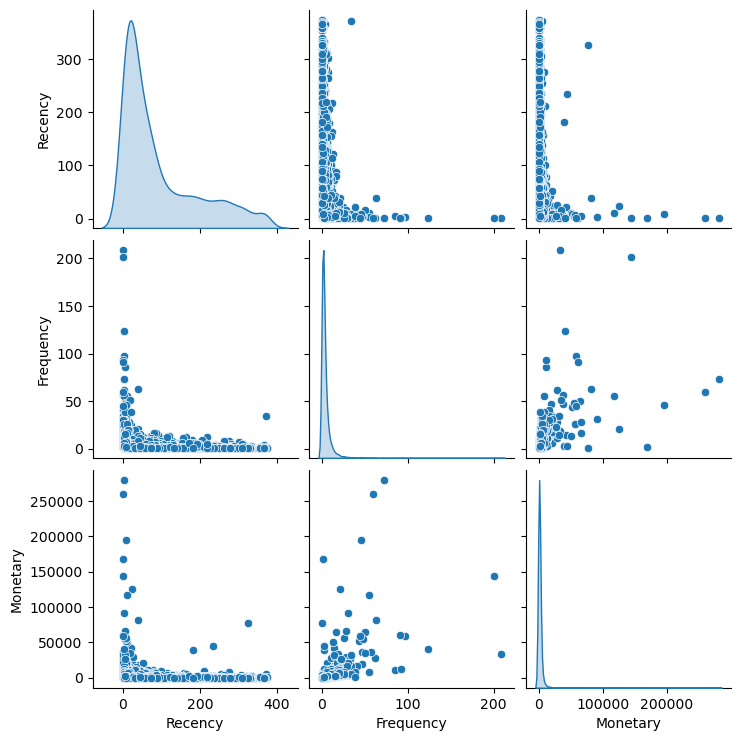

In [19]:
sns.pairplot(rfm, diag_kind='kde')
plt.show()

In [20]:
from scipy.stats import boxcox

rfm_transformed = pd.DataFrame()

rfm_transformed['Recency'], recency_lambda = boxcox(rfm['Recency'])
rfm_transformed['Frequency'], frequency_lambda = boxcox(rfm['Frequency'])
rfm_transformed['Monetary'], monetary_lambda = boxcox(rfm['Monetary'] +1e-6)  # Box-Cox dönüşümü için sıfırdan büyük olmalı

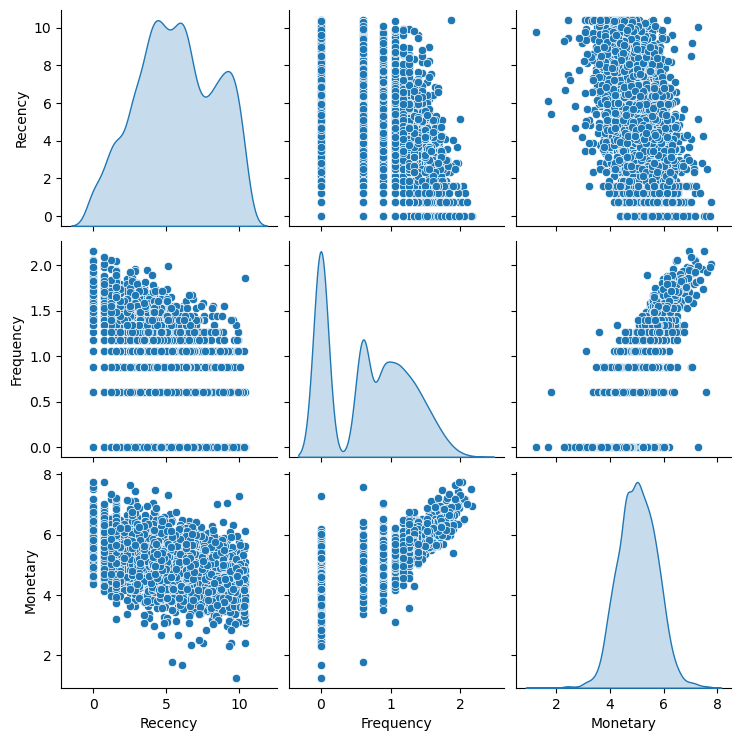

In [21]:
sns.pairplot(rfm_transformed, diag_kind='kde')
plt.show()

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_transformed)

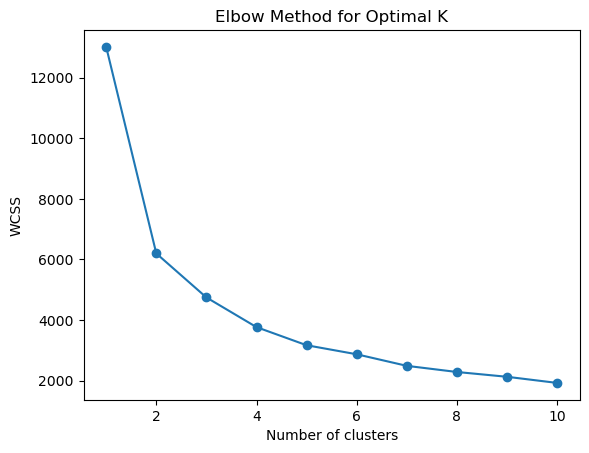

In [24]:
from sklearn.cluster import KMeans

wcss = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, init = 'k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)
    
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')   
plt.show()

In [25]:
optimal_k = 3

k_means = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
k_means.fit(rfm_scaled)

rfm['Cluster'] = k_means.labels_

In [26]:
rfm.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,0
12347.0,2,7,4310.00,1
12348.0,75,4,1797.24,0
12349.0,19,1,1757.55,0
12350.0,310,1,334.40,2


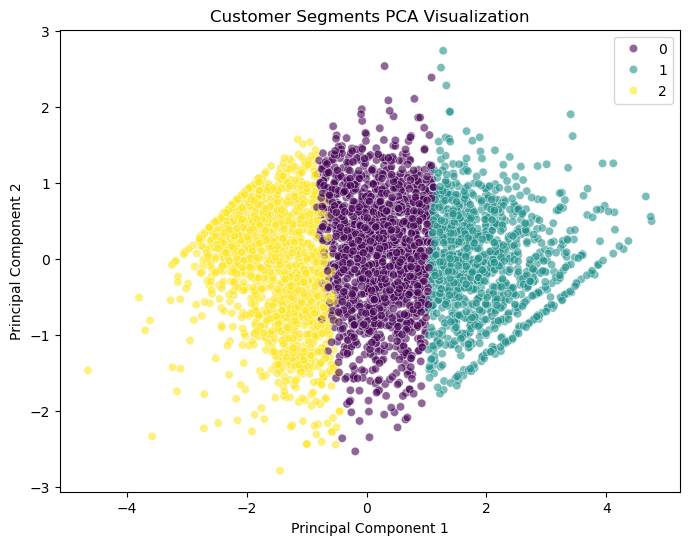

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

rfm['PCA1'] = rfm_pca[:, 0]
rfm['PCA2'] = rfm_pca[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue= rfm['Cluster'], palette='viridis', alpha=0.6)
plt.title('Customer Segments PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [28]:
cluster_means = rfm[['Cluster', 'Recency', 'Frequency', 'Monetary']].groupby('Cluster', as_index=False).mean()
print("\nCluster Means:")
print(cluster_means)


Cluster Means:
   Cluster     Recency  Frequency     Monetary
0        0   71.461394   2.974890  1036.709336
1        1   17.683746  10.581272  5968.221440
2        2  165.881587   1.125232   312.401278


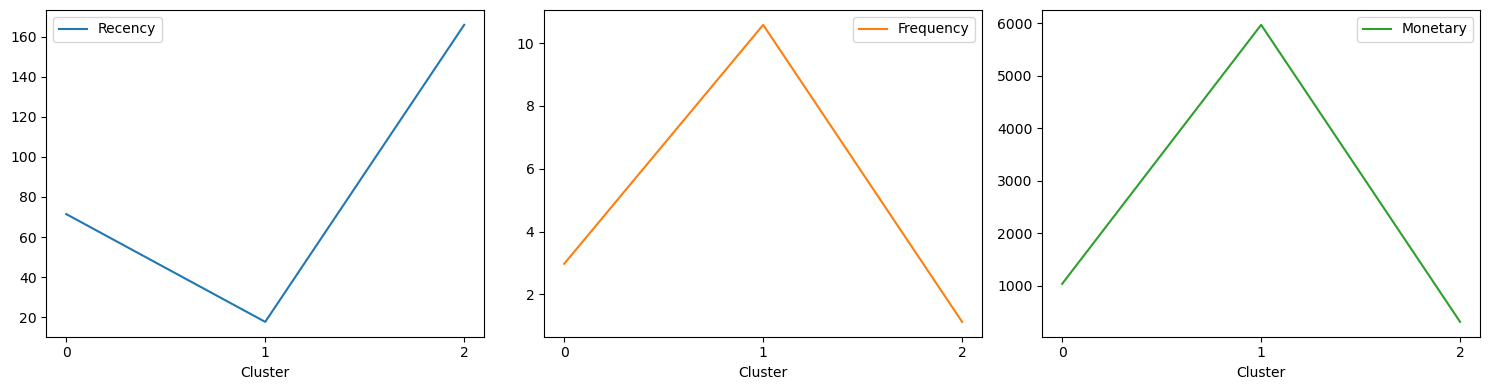

In [29]:
rfm[['Cluster', 'Recency', 'Frequency', 'Monetary']]\
   .groupby('Cluster')\
   .mean()\
   .plot(subplots=True, sharey=False, layout=(1, 3), figsize=(15, 4))

plt.xticks(ticks=[0, 1, 2])
plt.tight_layout()
plt.show()

In [30]:
def suggest_strategy(recency, frequency, monetary):
    if recency == 'Low' and frequency == 'High' and monetary == 'High':
        return "Reward and nurture - exclusive offers, loyalty programs, early access to new products."
    elif recency == 'High' and frequency == 'Low' and monetary == "Low":
        return "Re-engagement and retention - win-back promotions, personalized emails, surveys."
    elif recency == 'Low' and frequency == 'Low' and monetary == 'Low':  # Fixed = to == and fixed quotes
        return "Encourage repeat purchases - welcome emails, incentives for next purchase, product recommendations."
    elif recency == 'High' and frequency == 'Moderate' and monetary == 'Moderate':  # Fixed = to ==
        return "Re-activate and remind - targeted promotions, email campaigns highlighting new arrivals."
    elif recency == 'Low' and frequency == 'Moderate' and monetary == 'Moderate':
        return "Nurture and grow - provide excellent customer service, offer relevant product recommendations."
    elif recency == 'Moderate' and frequency == 'High' and monetary == 'Moderate':  # Fixed -- to == and - to ==
        return "Reward loyalty and encourage more frequent purchases - offer exclusive discounts, early access to sales."
    elif recency == 'Moderate' and frequency == 'Low' and monetary == 'Moderate':  # Fixed = to == and . to ==
        return "Re-engage and offer personalized recommendations - remind them of past purchases, offer discounts on similar items."  # Fixed unterminated string
    elif recency == 'Moderate' and frequency == 'Moderate' and monetary == 'High':  # Fixed = to == and •= to ==
        return "Encourage larger purchases - offer premium products, cross-selling opportunities, personalized consultations."  # Fixed spelling
    elif recency == 'High' and frequency == 'High' and monetary == 'High':
        return "Re-engage and offer personalized recommendations - remind them of past purchases, offer discounts on similar items."
    elif recency == 'Low' and frequency == 'High' and monetary == 'Moderate':
        return "Reward loyalty and encourage more frequent purchases - offer exclusive discounts, early access to sales."
    else:
        return "Further analysis and tailored strategy required."

strategy = suggest_strategy('Low', 'High', 'High')
print(strategy)

Reward and nurture - exclusive offers, loyalty programs, early access to new products.


In [31]:
print("**"*30)
print("strategy for clusters 0: \n" , suggest_strategy("Modarete", "Low", "Low"))
print("**"*30)
print("strategy for clusters 1: \n" , suggest_strategy( "Low", "High", "high"))
print("**"*30)
print("strategy for clusters 2: \n" , suggest_strategy( "High", "Low", "Low"))

************************************************************
strategy for clusters 0: 
 Further analysis and tailored strategy required.
************************************************************
strategy for clusters 1: 
 Further analysis and tailored strategy required.
************************************************************
strategy for clusters 2: 
 Re-engagement and retention - win-back promotions, personalized emails, surveys.


In [32]:
rfm_melted = pd.melt(rfm.reset_index(),
                     id_vars=['Cluster'],
                     value_vars=['Recency', 'Frequency', 'Monetary'],
                     var_name='Metric',
                     value_name='Value')

rfm_melted.head()

,Cluster,Metric,Value
0,0,Recency,326.0
1,1,Recency,2.0
2,0,Recency,75.0
3,0,Recency,19.0
4,2,Recency,310.0


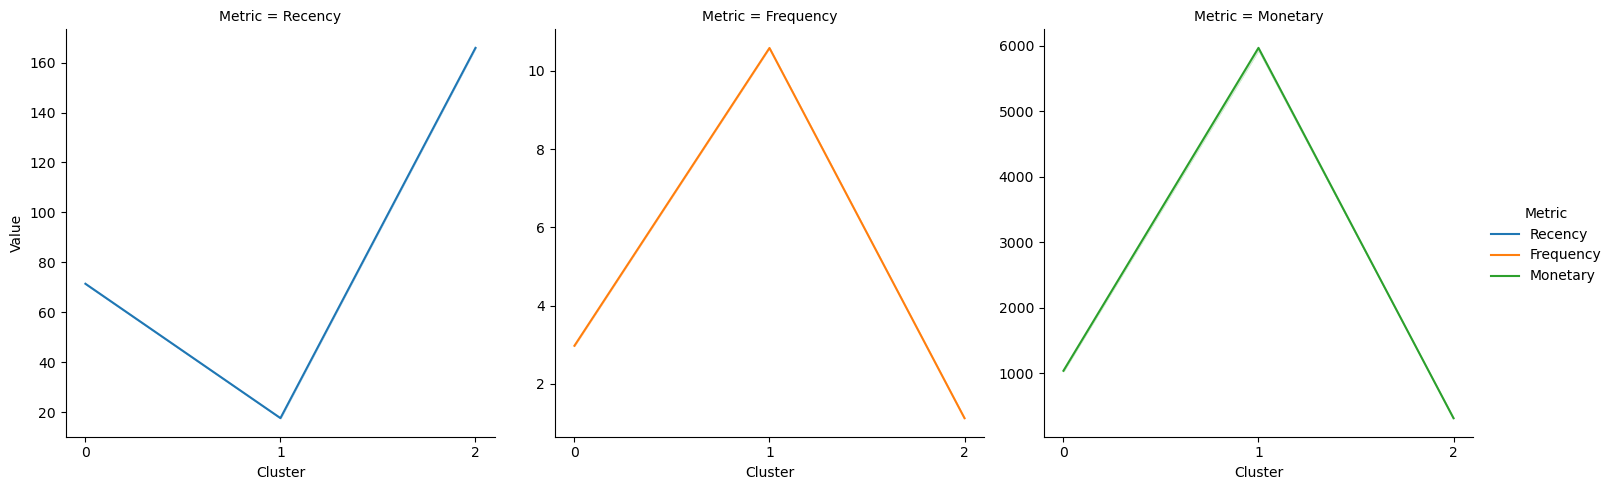

In [33]:
sns.relplot(x='Cluster', y='Value', data=rfm_melted, hue='Metric', kind='line',
            errorbar=('ci', False), col='Metric', facet_kws={'sharey': False})
plt.xticks(ticks=[0, 1, 2])
plt.show()

In [34]:
# Import the TSNE class from sklearn
from sklearn.manifold import TSNE

# Apply t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=42)
rfm_tsne = tsne.fit_transform(rfm_scaled)

# Add the t-SNE components to your DataFrame
rfm['TSNE1'] = rfm_tsne[:, 0]
rfm['TSNE2'] = rfm_tsne[:, 1]

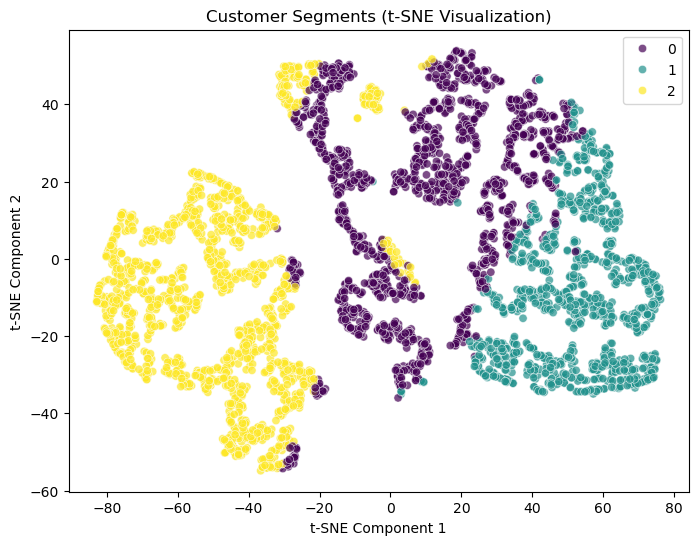

In [35]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', data=rfm, palette='viridis', alpha=0.7)
plt.title('Customer Segments (t-SNE Visualization)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

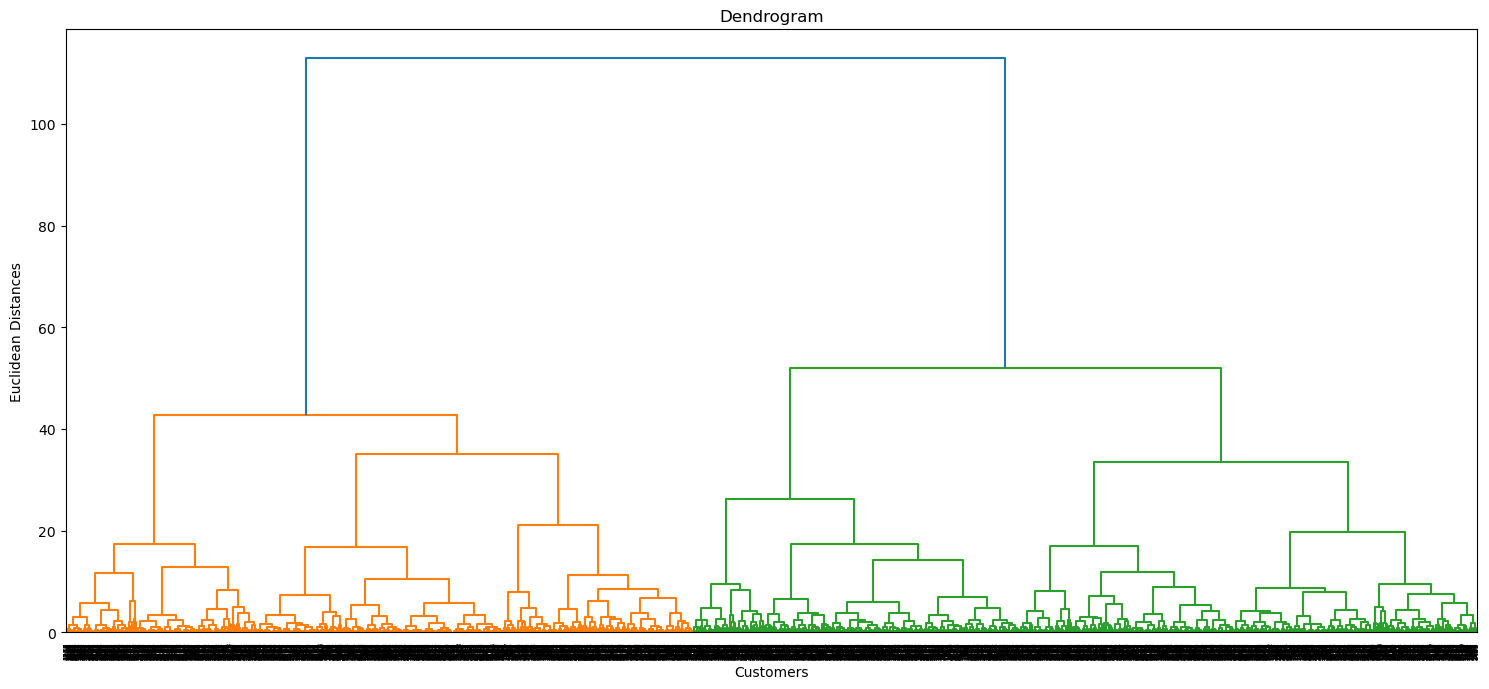

In [36]:
import scipy.cluster.hierarchy as sch

# Perform hierarchical clustering (using Ward's linkage)
plt.figure(figsize=(15, 7))
dendrogram = sch.dendrogram(sch.linkage(rfm_scaled, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.tight_layout()
plt.show()

In [37]:
# Son işlem tarihini bulma
latest_date = df['InvoiceDate'].max()

In [38]:
# RFM hesaplamaları
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',                                  # Frequency
    'TotalPrice': 'sum'                                     # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
})

In [39]:
# RFM skorları hesaplama (yüzdelik dilimlere göre)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

In [40]:
# RFM skoru birleştirme
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

In [41]:
# RFM segmentasyonu
def segment_customer(score):
    if score in ['555', '554', '454', '455', '355']:
        return 'Şampiyonlar'
    elif score in ['311', '411', '211']:
        return 'Kaçanlar'
    elif score in ['111', '112', '121', '122', '212']:
        return 'Kayıp'
    elif score in ['215', '221', '222', '213', '214', '215', '223', '231', '232', '233', '234', '235']:
        return 'Uyuyanlar'
    elif score in ['312', '313', '314', '315', '321', '322', '323', '324', '325', '331', '332', '333', '334', '335']:
        return 'Potansiyel Sadıklar'
    elif score in ['412', '413', '414', '415', '421', '422', '423', '424', '425', '431', '432', '433', '434', '435']:
        return 'Yeni Müşteriler'
    elif score in ['512', '513', '514', '515', '521', '522', '523', '524', '525', '531', '532', '533', '534', '535']:
        return 'Sadık Müşteriler'
    else:
        return 'Diğer'

In [42]:
rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

print("\nRFM Segmentasyonu:")
print(rfm.head())


RFM Segmentasyonu:
            Recency  Frequency  Monetary  R_Score  F_Score  M_Score RFM_Score  \
CustomerID                                                                      
12346.0         325          1  77183.60        1        1        5       115   
12347.0           1        182   4310.00        5        5        5       555   
12348.0          74         31   1797.24        2        3        4       234   
12349.0          18         73   1757.55        4        4        4       444   
12350.0         309         17    334.40        1        2        2       122   

                Segment  
CustomerID               
12346.0           Diğer  
12347.0     Şampiyonlar  
12348.0       Uyuyanlar  
12349.0           Diğer  
12350.0           Kayıp  


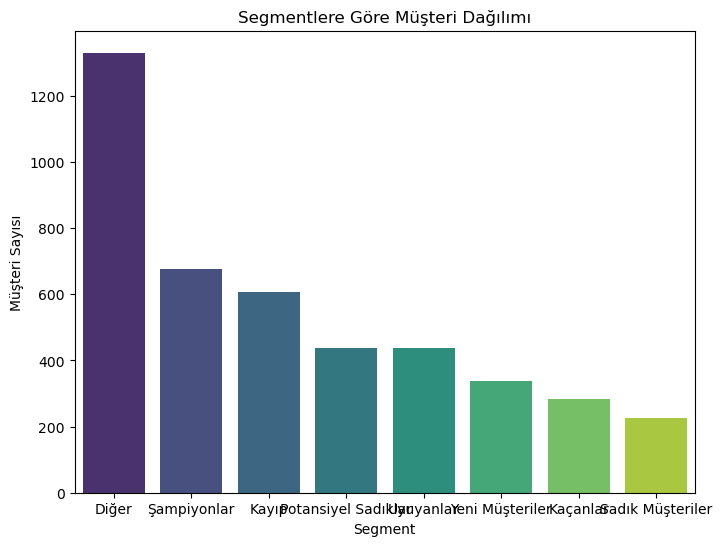

In [43]:
segment_counts = rfm['Segment'].value_counts()

# Bar grafiği çizimi
plt.figure(figsize=(8, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
plt.xlabel('Segment')
plt.ylabel('Müşteri Sayısı')
plt.title('Segmentlere Göre Müşteri Dağılımı')
plt.show()

# Kmeans

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [46]:
# RFM değerlerini ölçeklendirme
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

In [47]:
rfm_df=df.copy()

In [48]:
from sklearn.neighbors import BallTree  # BallTree, veri noktaları arasındaki uzaklık sorgularını hızlı bir şekilde gerçekleştirmek için kullanılan bir veri yapısıdır.
def hopkins(data_frame, sampling_size):
    """Assess the clusterability of a dataset. A score between 0 and 1, a score around 0.5 express
    no clusterability and a score tending to 0 express a high cluster tendency.
    Parameters
    ----------
    data_frame : numpy array
        The input dataset
    sampling_size : int
        The sampling size which is used to evaluate the number of DataFrame.
    Returns
    ---------------------
    score : float
        The hopkins score of the dataset (between 0 and 1)
    Examples
    --------
    >>> from sklearn import datasets
    >>> from pyclustertend import hopkins
    >>> X = datasets.load_iris().data
    >>> hopkins(X,150)
    0.16
    """
    if type(data_frame) == np.ndarray:
        data_frame = pd.DataFrame(data_frame)
    # Sample n observations from D : P
    if sampling_size > data_frame.shape[0]:
        raise Exception(
            'The number of sample of sample is bigger than the shape of D')
    data_frame_sample = data_frame.sample(n=sampling_size)
    # Get the distance to their neirest neighbors in D : X
    tree = BallTree(data_frame, leaf_size=2)
    dist, _ = tree.query(data_frame_sample, k=2)
    data_frame_sample_distances_to_nearest_neighbours = dist[:, 1]
    # Randomly simulate n points with the same variation as in D : Q.
    max_data_frame = data_frame.max()
    min_data_frame = data_frame.min()
    uniformly_selected_values_0 = np.random.uniform(min_data_frame[0], max_data_frame[0], sampling_size)
    uniformly_selected_values_1 = np.random.uniform(min_data_frame[1], max_data_frame[1], sampling_size)
    uniformly_selected_observations = np.column_stack((uniformly_selected_values_0, uniformly_selected_values_1))
    if len(max_data_frame) >= 2:
        for i in range(2, len(max_data_frame)):
            uniformly_selected_values_i = np.random.uniform(min_data_frame[i], max_data_frame[i], sampling_size)
            to_stack = (uniformly_selected_observations, uniformly_selected_values_i)
            uniformly_selected_observations = np.column_stack(to_stack)
    uniformly_selected_observations_df = pd.DataFrame(uniformly_selected_observations)
    # Get the distance to their neirest neighbors in D : Y
    tree = BallTree(data_frame, leaf_size=2)
    dist, _ = tree.query(uniformly_selected_observations_df, k=1)
    uniformly_df_distances_to_nearest_neighbours = dist
    # return the hopkins score
    x = sum(data_frame_sample_distances_to_nearest_neighbours)
    y = sum(uniformly_df_distances_to_nearest_neighbours)
    if x + y == 0:
        raise Exception('The denominator of the hopkins statistics is null')
    return x / (x + y)[0]

In [49]:
hopkins(rfm_scaled, rfm_scaled.shape[0] )

np.float64(0.009324453707889244)

In [50]:
# Optimum küme sayısını bulma (Elbow Method ve Silhouette Analysis)
sse = []
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)
    score = silhouette_score(rfm_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

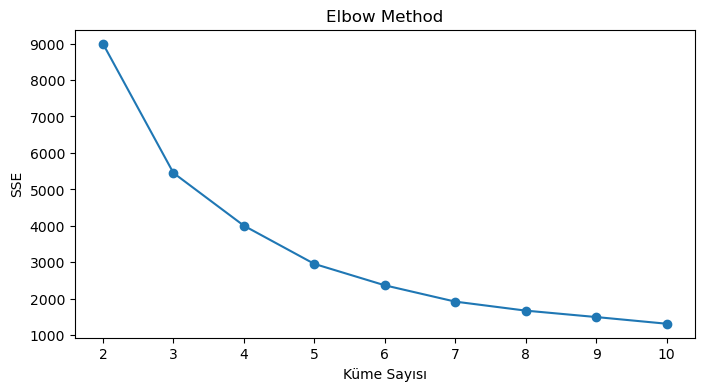

In [51]:
# Elbow Method grafiği
plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Küme Sayısı')
plt.ylabel('SSE')
plt.show()

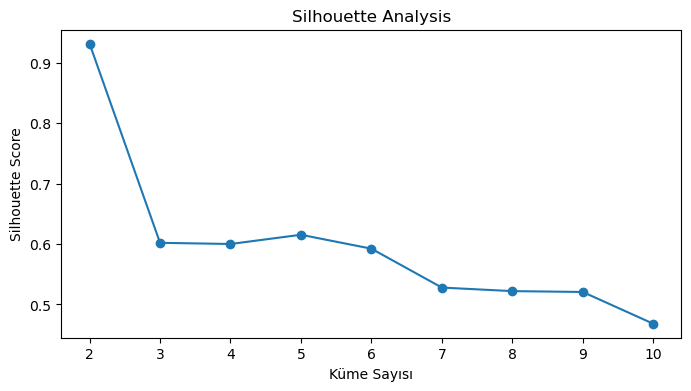

In [52]:
# Silhouette Analysis grafiği
plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouette_coefficients, marker='o')
plt.title('Silhouette Analysis')
plt.xlabel('Küme Sayısı')
plt.ylabel('Silhouette Score')
plt.show()

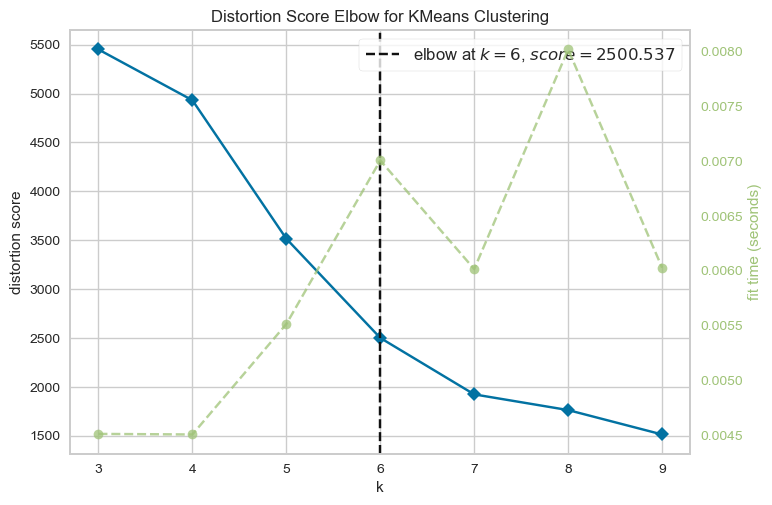

In [53]:
from yellowbrick.cluster import KElbowVisualizer

model_ = KMeans(random_state=42)
visualizer = KElbowVisualizer(model_, k=(3,10))

visualizer.fit(rfm_scaled)        # Fit the data to the visualizer
visualizer.show(); 

## distortion=inertia

In [54]:
range_n_clusters = range(3,10)
for num_clusters in range_n_clusters:
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(rfm_scaled)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    print(f"For n_clusters={num_clusters}, the silhouette score is {silhouette_avg}")

For n_clusters=3, the silhouette score is 0.6019775931686978
For n_clusters=4, the silhouette score is 0.3588023011776161
For n_clusters=5, the silhouette score is 0.3599790938322134
For n_clusters=6, the silhouette score is 0.5133606176751524
For n_clusters=7, the silhouette score is 0.5225734448733069
For n_clusters=8, the silhouette score is 0.5244388648874353
For n_clusters=9, the silhouette score is 0.504623773366762


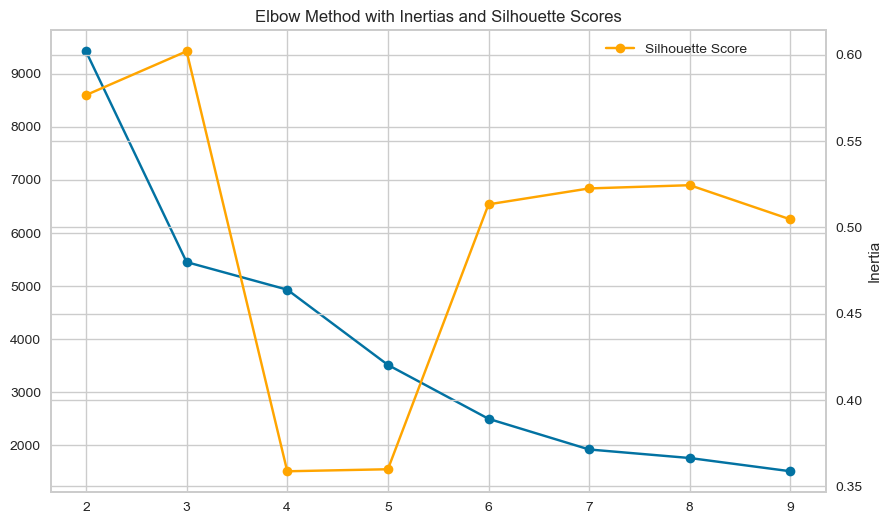

In [55]:
# Elbow + Silhoutee skorunu bir arada gösteren grafik

inertia_scores = []
silhouette_scores = []
for i in range(2, 10):
    model = KMeans(n_clusters=i, random_state=42)
    labels = model.fit_predict(rfm_scaled)
    silhouette = silhouette_score(rfm_scaled, labels)
    inertia = model.inertia_
    inertia_scores.append(inertia)
    silhouette_scores.append(silhouette)
    
# Plotting the Elbow Method with Inertias and Silhouette Scores
plt.figure(figsize=(10, 6))

# Plot Inertias
plt.plot(range(2,10), inertia_scores, label='Inertia', marker='o')

# Plot Silhouette Scores on a secondary y-axis
plt.twinx()
plt.plot(range(2,10), silhouette_scores, label='Silhouette Score', marker='o', color='orange')

# Add labels, title, and legend
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method with Inertias and Silhouette Scores')
plt.legend(loc='upper left', bbox_to_anchor=(0.7, 1))
plt.show()

In [56]:
ssd = []  #inertia mesafelerin karelerinin toplamı

K = range(3,10)

for k in K:
    model = KMeans(n_clusters = k, random_state = 42)
    model.fit(rfm_scaled)
    ssd.append(model.inertia_)

In [57]:
ssd

[5451.751192923712,
 4932.430400350042,
 3515.554959233251,
 2500.5368110184163,
 1922.9077664562533,
 1762.1876520479243,
 1512.6441504935933]

In [58]:
# Kullanıcıdan küme sayısını al
n_clusters = int(input("Lütfen optimum küme sayısını girin (Örn: 3): "))

Lütfen optimum küme sayısını girin (Örn: 3):  3


In [86]:
print(len(rfm_scaled))  # 4338
print(len(rfm_df))      # 397884

4338
397884


In [88]:
print(rfm_scaled.shape)
print(rfm_df.shape)

(4338, 3)
(397884, 9)


In [94]:
# K-Means modelini oluşturma ve eğitme
kmeans = KMeans(n_clusters=n_clusters, random_state=42, init='k-means++')
kmeans.fit(rfm_scaled)

KMeans(n_clusters=3, random_state=42)

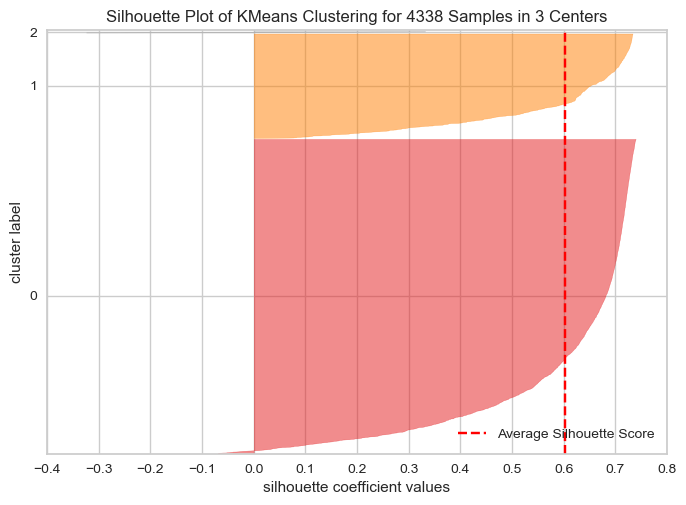

In [96]:
from yellowbrick.cluster import SilhouetteVisualizer

visualizer = SilhouetteVisualizer(kmeans)

visualizer.fit(rfm_scaled)    # Fit the data to the visualizer
visualizer.poof();

In [98]:
final_model = KMeans(n_clusters = 3, random_state = 42)
final_model.fit_predict(rfm_scaled)

array([1, 0, 0, ..., 0, 0, 0], dtype=int32)

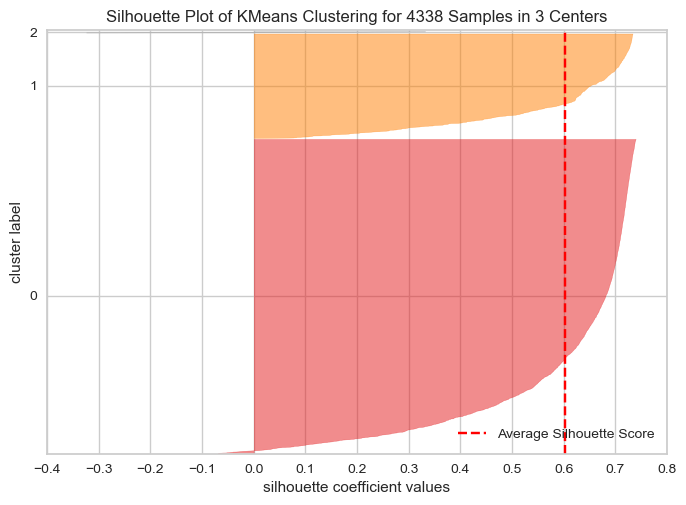

In [99]:
from yellowbrick.cluster import SilhouetteVisualizer

final_model = KMeans(3, random_state=42)
visualizer = SilhouetteVisualizer(final_model)

visualizer.fit(rfm_scaled)    # Fit the data to the visualizer
visualizer.poof();

In [100]:
# Convert the NumPy array to a pandas DataFrame first, then sample
import pandas as pd

# Assuming rfm_scaled is your NumPy array
rfm_scaled_df = pd.DataFrame(rfm_scaled)

# Now you can use the sample method
rfm_scaled_df.sample(10)

# If you had column names in your original data, you can add them:
# rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['col1', 'col2', ...])

,0,1,2
1996,0.804615,-0.186750,-0.130551
2215,0.034635,-0.274178,-0.126953
2787,-0.835342,0.578249,0.194168
3144,-0.615348,-0.182378,-0.088645
3024,-0.585349,0.246021,-0.050155
3626,-0.675346,0.171707,0.052697
848,1.404599,-0.300407,-0.178014
1061,1.584594,-0.326635,-0.214329
2084,0.274629,-0.178007,-0.112364
426,-0.685346,-0.042493,-0.186222


In [101]:
new_data = [
    [1160, 876, 2787],
    [2916, 2711, 1963],
    [639, 261, 183]
]

new_data_scaled = scaler.transform(new_data)
prediction = final_model.predict(new_data_scaled)
print(f"Müşteri kümeleri: {prediction}")

Müşteri kümeleri: [1 1 1]


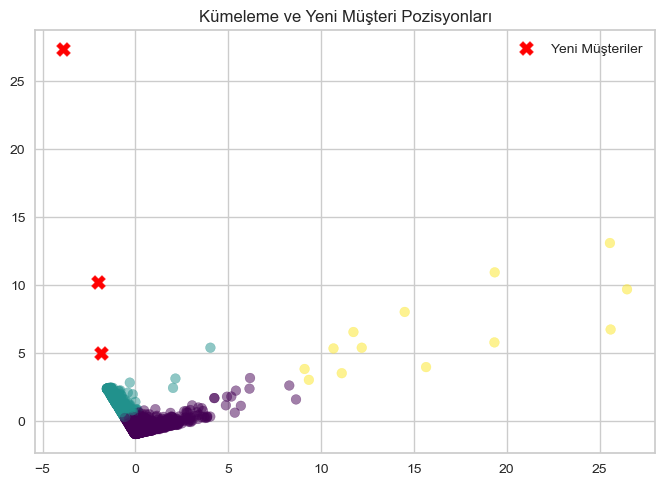

In [102]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Varsayalım train_data_scaled model eğitimi için kullanıldı
pca = PCA(n_components=2)
train_pca = pca.fit_transform(rfm_scaled)
new_pca = pca.transform(new_data_scaled)

plt.scatter(train_pca[:, 0], train_pca[:, 1], c=final_model.predict(rfm_scaled), cmap='viridis', alpha=0.5)
plt.scatter(new_pca[:, 0], new_pca[:, 1], c='red', label='Yeni Müşteriler', marker='X', s=100)
plt.legend()
plt.title("Kümeleme ve Yeni Müşteri Pozisyonları")
plt.show()

# Cohort Analysis

**Cohort Analizi (Cohort Analysis)**

Cohort analizi, belirli zaman dilimlerinde veya davranışsal özelliklere göre gruplandırılmış kullanıcıların davranışlarını incelemek için kullanılan bir analiz yöntemidir. Özellikle müşteri tutma oranlarını ve kullanıcıların zaman içindeki davranışlarını analiz etmek için faydalıdır.

**Cohort Nedir?**
Cohort, belirli bir ortak özelliği paylaşan bir grup insan veya müşteri demektir. Örneğin:
- **Kaydolma tarihi**: Belirli bir ay içinde kaydolmuş kullanıcılar.
- **İlk alışveriş tarihi**: Belirli bir dönemde ilk alışveriş yapan müşteriler.

**Cohort Analizinin Amaçları:**
1. Müşteri tutma oranlarını analiz etmek.
2. Müşteri davranışlarındaki eğilimleri anlamak.
3. Pazarlama stratejilerinin etkinliğini ölçmek.
4. Zaman içinde müşteri gruplarının nasıl değiştiğini görmek.

**Nasıl Yapılır?**
Cohort Analysis genellikle müşterilerin ilk satın alma veya kayıt tarihine dayalı olarak yapılır. Temel adımlar şunlardır:

1. **Cohort Belirleme**: Analize dahil edilecek müşteri gruplarını tanımlayın. Örneğin, müşterileri kayıt tarihlerine göre aylık olarak gruplara ayırabilirsiniz.

2. **Müşteri Davranışlarının İzlenmesi**: Belirlenen her bir cohort için, müşterilerin zaman içindeki davranışlarını (örneğin, satın alma miktarı, tekrar satın alma oranı) izleyin.

3. **Gelişmelerin Analizi**: Her bir cohort için, zamanla değişen davranışları ve performansı analiz edin. Bu, özellikle cohort'un ilk etkileşimden sonraki davranışlarına ve müşteri yaşam döngüsüne odaklanır.

4. **Segmentasyon ve Karşılaştırma**: Elde edilen verileri analiz edin ve farklı cohort gruplarını karşılaştırın. Bu, belirli pazarlama stratejilerinin veya işletme değişikliklerinin cohort gruplarının davranışlarına nasıl etki ettiğini anlamak için önemlidir.

**Cohort Analizinin Kullanım Alanları:**
- **E-Ticaret:** Müşteri sadakatini ve satın alma eğilimlerini ölçmek.
- **SaaS Şirketleri:** Abonelik iptali (churn) oranını analiz etmek.
- **Mobil Uygulamalar:** Kullanıcıların aktif kalma oranlarını görmek.
  
**Cohort Analizinin Faydaları**

- **Müşteri Davranışlarının Anlaşılması**: Hangi müşteri gruplarının işletme için en değerli olduğunu ve nasıl davrandığını anlamak için değerli bir yol sağlar.

- **Pazarlama Stratejilerinin Optimizasyonu**: Cohort Analysis, pazarlama stratejilerinin etkilerini değerlendirmek ve optimize etmek için kullanılabilir.

- **Sadakat ve Müşteri İlişkileri Yönetimi**: Müşteri sadakati ve ilişkilerinin zaman içinde nasıl değiştiğini anlamak için kullanılabilir.

**Örnek Analiz Soruları:**
- Yeni müşteriler ilk alışverişlerinden sonra ne kadar süre bağlı kalıyor?
- Pazarlama kampanyası belirli bir dönemdeki müşterileri nasıl etkiledi?
- Müşteri tutma oranı zamanla artıyor mu, azalıyor mu?

---

**RFM Analizi ve Cohort Analizi Arasındaki Farklar:**
| **RFM Analizi**                         | **Cohort Analizi**                     |
|------------------------------------------|-----------------------------------------|
| Müşterileri bireysel skorlarla değerlendirir. | Müşterileri gruplar halinde inceler.    |
| Daha çok müşteri segmentasyonu için kullanılır. | Müşteri davranışlarını analiz etmek için uygundur. |
| Hedefi, müşterinin güncel ve geçmiş davranışlarını değerlendirmektir. | Zaman içindeki eğilimleri analiz etmeye odaklanır. |

In [105]:
# İlk satın alma tarihini bulma
df['First_Purchase'] = df.groupby('CustomerID')['InvoiceDate'].transform('min')

In [106]:
# Cohort'u belirleme (ay bazında)
df['First_Purchase_Month'] = df['First_Purchase'].dt.to_period('M')
df['Invoice_Month'] = df['InvoiceDate'].dt.to_period('M')

In [107]:
# Cohort boyutunu hesaplama
df['Cohort_Size'] = df.groupby('First_Purchase_Month')['CustomerID'].transform('nunique')

In [108]:
# Cohort tablosunu oluşturma
cohort_group = df.groupby(['First_Purchase_Month', 'Invoice_Month']).agg(n_customers=('CustomerID', 'nunique')).reset_index()
cohort_group['Period_Number'] = (cohort_group['Invoice_Month'] - cohort_group['First_Purchase_Month']).apply(lambda x: x.n)
cohort_pivot = cohort_group.pivot_table(index='First_Purchase_Month', columns='Period_Number', values='n_customers')

In [109]:
# Müşteri tutma oranını hesaplama
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

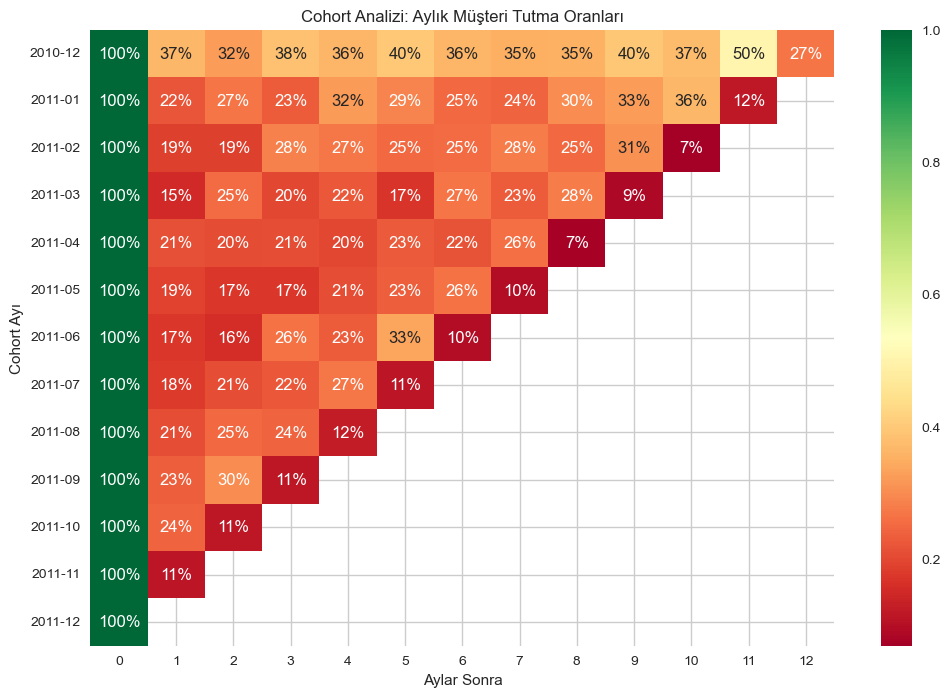

In [110]:
# Müşteri tutma oranını görselleştirme
plt.figure(figsize=(12, 8))
sns.heatmap(retention_matrix, annot=True, fmt='.0%', cmap='RdYlGn')
plt.title('Cohort Analizi: Aylık Müşteri Tutma Oranları')
plt.xlabel('Aylar Sonra')
plt.ylabel('Cohort Ayı')
plt.show()

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
# 1. Tarih dönüşümünü garanti altına al
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [113]:
# 2. İlk satın alma tarihi
df['First_Purchase'] = df.groupby('CustomerID')['InvoiceDate'].transform('min')

In [114]:
# 3. Ay bazında cohort belirleme
df['First_Purchase_Month'] = df['First_Purchase'].dt.to_period('M')
df['Invoice_Month'] = df['InvoiceDate'].dt.to_period('M')

In [115]:
# 4. Cohort tablosunu oluşturma
cohort_group = df.groupby(['First_Purchase_Month', 'Invoice_Month']) \
    .agg(n_customers=('CustomerID', 'nunique')) \
    .reset_index()

In [116]:
# 5. Kaçıncı ay (dönem farkı)
cohort_group['Period_Number'] = (cohort_group['Invoice_Month'] - cohort_group['First_Purchase_Month']).apply(lambda x: x.n)

In [117]:
# 6. Pivot tablo
cohort_pivot = cohort_group.pivot_table(index='First_Purchase_Month', 
                                        columns='Period_Number', 
                                        values='n_customers')

In [118]:
# 7. Retention oranı
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

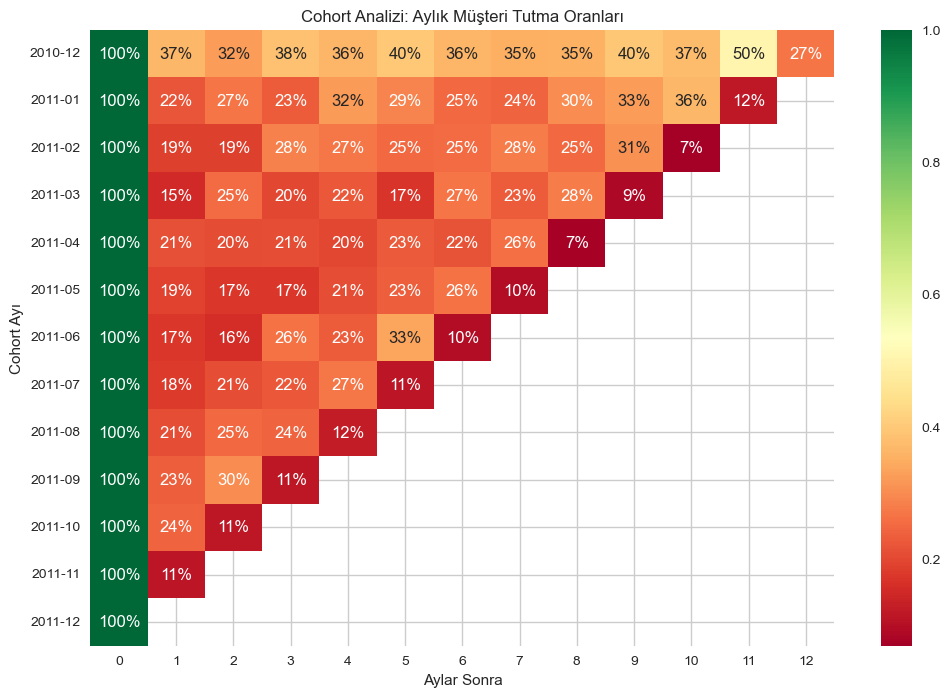

In [119]:
# 8. Heatmap görselleştirme
plt.figure(figsize=(12, 8))
sns.heatmap(retention_matrix, annot=True, fmt='.0%', cmap='RdYlGn', mask=retention_matrix.isnull())
plt.title('Cohort Analizi: Aylık Müşteri Tutma Oranları')
plt.xlabel('Aylar Sonra')
plt.ylabel('Cohort Ayı')
plt.show()

Görselin Anlamı ve Yorumu:
🔹 Cohort Ayı (Sol Y Ekseni):
•	Her satır, bir müşteri grubunu (cohort) temsil eder. Örneğin, 2010-12 cohort'u, ilk kez Aralık 2010'da alışveriş yapan müşterileri kapsar.

🔹 Aylar Sonra (Alt X Ekseni):
•	Bu eksen, müşterilerin ilk alışverişlerinden kaç ay sonra tekrar alışveriş yaptığını gösterir.
Örneğin:
o	0. ay = İlk alışveriş ayı
o	
1.	ay = Ertesi ay
o	...
o	
12.	ay = Bir yıl sonra



🔹 Hücre Değerleri (%):
•	Her hücredeki oran, o cohort'taki müşterilerin belirli bir ay sonra hâlâ aktif (alışveriş yapan) olup olmadığını gösterir.

Örneğin:
o	2010-12 cohort'u, 1 ay sonra %37'sini tutabilmiş.
o	Aynı grup 12 ay sonra hâlâ %27 aktifmiş.

🔹 Renk Skalası:

•	Yeşil: Yüksek müşteri tutma oranı
•	Kırmızı: Düşük tutma oranı
	
1.	ay (ilk alışveriş ayı) her zaman %100’dür.

•	Hangi dönemlerde gelen müşteriler daha sadık?
Örneğin, 2010-12 cohort'undaki müşteriler diğer aylara göre daha iyi tutma oranına sahip.

•	Müşteri sadakati genel olarak nasıl seyrediyor?
Genellikle ilk aylarda ciddi düşüş gözlemleniyor. Örn: 1. ayda %20-30'lara iniyor.


•	Pazarlama kampanyalarının etkisi ölçülebilir.

Belirli aylarda (örneğin 2011-06'da 5. ayda %33'e sıçrama) bir kampanya olabilir.


2010-12 Cohort Detaylı Analizi

•	Bu grup, en yüksek sadakat oranına sahip.
•	12 ay boyunca müşteri tutma oranları göreceli olarak daha yüksek seyrediyor.


Ay (Sonrası)	Tutulan Müşteri Oranı	Açıklama

0. ay	%100	İlk alışverişlerini yapan tüm müşteriler.
1. ay	%37	Müşterilerin %37'si sonraki ay tekrar alışveriş yaptı.
2. ay	%32	%32'si 2. ayda aktif kaldı.
3. ay	%38	İlginç bir şekilde artış gözlenmiş. Muhtemelen kampanya etkisi olabilir.
4. ay	%36	İstikrar devam ediyor.
5. ay	%40	Yine bir artış; sadık müşteri kitlesi oluşmuş olabilir.
6. ay	%36	Düşüşe rağmen hâlâ yüksek.
7. ay	%35	Küçük bir azalma.
8. ay	%40	Yeniden yükselme—belki de özel bir promosyon dönemi.
9. ay	%37	Oldukça istikrarlı bir sadakat eğrisi.
10. ay	%50	En yüksek oranlardan biri. Kampanya, sezon, vb. etkili olabilir.
11. ay	-	Veri yok veya analiz dışı bırakılmış olabilir.
12. ay	%27	1 yıl sonra müşterilerin dörtte biri hâlâ aktif. Bu, e-ticaret için güçlü bir orandır.


•	Sadakat eğrisi çok sağlam:
Genelde birçok cohort ilk 2–3 ayda %10'un altına düşerken, bu grup 12. ayda bile %27 ile devam ediyor.

•	Dalgalanmalar dikkat çekici: 
3., 5., 8. ve 10. aylarda küçük artışlar var → muhtemelen kampanya, sezon veya belirli stratejik aksiyonlarla ilişkilidir.

•	Müşteri kalitesi yüksek olabilir: 
Belki bu dönemde gelen müşteriler daha büyük kurumsal müşterilerdi, belki reklam stratejisi daha isabetliydi.


Bu Cohort’a Dönük Eylem Önerileri:

•	Bu cohort'un ilk aylarındaki pazarlama stratejileri incelenmeli → aynı taktikler diğer cohort'lara da uygulanabilir.

•	Sadık müşteri profili çıkarılmalı: Bu müşteriler hangi ürünleri aldı, nereden geldi (kanal), ortalama sepet tutarı neydi?

•	
10.	aydaki %50 artışın nedeni araştırılmalı: Sezonsal bir artış mı yoksa kampanya mı?


In [127]:
retention_matrix.idxmax(axis=1)
## 	•	Daha fazla analiz için monetary veya frequency boyutları da eklendi.
##	•	RFM analizi ile birlikte kullanılabilir.
##	•	İlk ay (%100) dışında en iyi tutunma hangi ayda, hangi cohort’ta olmuş bunu analiz etmek için:

First_Purchase_Month
2010-12    0
2011-01    0
2011-02    0
2011-03    0
2011-04    0
2011-05    0
2011-06    0
2011-07    0
2011-08    0
2011-09    0
2011-10    0
2011-11    0
2011-12    0
Freq: M, dtype: int64

Görünüyor ki tüm aylar için "0" değeri alınmış, yani her cohort için "ilk ay dışında" en yüksek müşteri tutma oranı 0. ayda çıkıyor gibi yorumlanmış.

Bu da analizinizde küçük bir hata olabileceğini gösteriyor.

0. ayı da dahil ederek maksimum değeri veriyor. Ama 0. ay her zaman %100 olduğundan bu, anlamlı bir analiz olmaz.


In [129]:
# 0. ayı dışarıda bırak
retention_matrix_wo_month_0 = retention_matrix.iloc[:, 1:]

# Her cohort için en yüksek tutunma hangi ayda olmuş (ilk ay hariç)
best_months = retention_matrix_wo_month_0.idxmax(axis=1)
print(best_months)


First_Purchase_Month
2010-12    11.0
2011-01    10.0
2011-02     9.0
2011-03     8.0
2011-04     7.0
2011-05     6.0
2011-06     5.0
2011-07     4.0
2011-08     2.0
2011-09     2.0
2011-10     1.0
2011-11     1.0
2011-12     NaN
Freq: M, dtype: float64


In [130]:
# En yüksek oranı ve ayı birlikte göster
max_values = retention_matrix_wo_month_0.max(axis=1)
max_months = retention_matrix_wo_month_0.idxmax(axis=1)

result_df = pd.DataFrame({
    'Best Month': max_months,
    'Retention Rate': max_values.round(2)
})

print(result_df)


                      Best Month  Retention Rate
First_Purchase_Month                            
2010-12                     11.0            0.50
2011-01                     10.0            0.36
2011-02                      9.0            0.31
2011-03                      8.0            0.28
2011-04                      7.0            0.26
2011-05                      6.0            0.26
2011-06                      5.0            0.33
2011-07                      4.0            0.27
2011-08                      2.0            0.25
2011-09                      2.0            0.30
2011-10                      1.0            0.24
2011-11                      1.0            0.11
2011-12                      NaN             NaN


🧠 Yorumlar:

✅ Güçlü Cohort’lar:

2010-12 cohort’u 11. ayda bile %50 müşteri tutmuş. Bu olağanüstü bir sadakat göstergesidir.


2011-06 da dikkat çekici: 5. ayda %33 oranla zirve yapmış.



2011-09 da 2. ayda %30 ile oldukça iyi performans göstermiş.

⏳ Tutunmanın Geç Zirve Yaptığı Cohort’lar:

2010-12, 2011-01, 2011-02… gibi cohort’lar zirveyi çok geç (8–11. aylar arasında) yapmış.

Bu, müşterilerin geç geri döndüğünü, belki de tekrarlı kampanyaların etkili olduğunu gösterir.


🚨 Zayıf Cohort’lar:

2011-11 ve 2011-12 oldukça zayıf. Bu dönemlerde gelen müşteriler ya kalitesizdi ya da ortam (sezon, kampanya, ürün, stok vs.) uygun değildi.

1. 🎯 En Güçlü Cohort: 2010-12

Tutunma Oranı: %50 (en yüksek)


Strateji: Bu dönemde uygulanan kampanyalar, ürün gamı veya pazarlama stratejileri başarılı olmuş olabilir.
    

📌 Bu dönemin kampanya ve müşteri deneyimlerini analiz et, yeniden uygulanabilir mi?


📦 Ürün portföyü, fiyat politikası veya müşteri hizmetleri özelinde retrospektif yapılabilir.




2. 🕑 Tutunma Ayı ile İlk Alışveriş Arası Ortalama: ~9-10 Ay

Müşteriler en fazla yaklaşık 9 ay sonra tekrar satın alım yapmış.
    

Strateji:


🎁 Sadakat programları veya hatırlatma kampanyaları bu zaman diliminde yoğunlaştırılmalı.
    

📅 3., 6., 9. aylarda e-posta dizileri ve promosyonlar planlanabilir.
    

3. 🧊 Zayıf Cohortlar: 2011-11 & 2011-12

Tutunma oranı çok düşük (%11 ve eksik)


Strateji:


❌ Yıl sonu döneminde müşteriyi elde tutma başarısız → sezon dışı olabilir mi?


📉 Kargo problemleri, stok sorunları veya düşük ürün kalitesi gibi operasyonel sıkıntılar olabilir.
    

🔍 2011 Q4 için memnuniyet verisi veya iade oranı analiz edilmeli.


4. 🔁 İlk Alışverişten Sonra 2. Alışverişe Yönlendirme Zayıf

veya 3. aydan sonra çoğu cohortun retention oranı düşüyor.


Strateji:


🚀 “İkinci alışveriş indirimi” kampanyası planlanabilir (%20 indirim, ücretsiz kargo).


🔄 Otomatik e-posta hatırlatmaları: “Sizi tekrar görmek istiyoruz!”




5. 💡 Genel Strateji Önerileri

Hedef	Öneri

Yeni müşteriler	1-3. ay arasında cross-sell & tekrar alım kampanyaları

Sadık müşteriler	6-9. ay arası ödül/hediye teşvikleri

Kaybedilen cohortlar	“Seni özledik” e-postası + özel indirim

Yıl sonu müşterileri	Tatil sezonuna özel erken kampanyalar


In [138]:
retention_matrix.iloc[:, 1:].idxmax(axis=1)

First_Purchase_Month
2010-12    11.0
2011-01    10.0
2011-02     9.0
2011-03     8.0
2011-04     7.0
2011-05     6.0
2011-06     5.0
2011-07     4.0
2011-08     2.0
2011-09     2.0
2011-10     1.0
2011-11     1.0
2011-12     NaN
Freq: M, dtype: float64